[13 丢弃法【动手学深度学习v2】](https://www.bilibili.com/video/BV1Y5411c7aY?spm_id_from=333.999.0.0)

- 截止目前的标准处理流程
- $h = σ(W_1x+b_1)$     第一个隐藏层
- $h' = dropout(h)$     进行随机的删除
- $o = W_2h'+b_2$       第二层输出
- $y = softmax(o)$      softmax层输出

In [8]:
import torch
from torch import nn
from d2l import torch as d2l

In [9]:
# 这里定义丢弃函数
def dropout_layer(X,dropout):
    assert 0 <= dropout <=1 # 概率肯定是在0-1之间
    if dropout ==1:
        return torch.zeros_like(X)
    if dropout ==0:
        return X
    # mask矩阵为0-1之间的均匀随机分布，大于dropout为1小于为0
    mask = (torch.randn(X.shape)>dropout).float()
    # 优先使用乘法而不是X[mask]=0，乘法速度远大于选取
    return mask*X/(1.0-dropout)

In [10]:
# torch.tensor.uniform从均匀分布中抽样数值进行填充  
torch.zeros(3,3).uniform_(0,1)

tensor([[0.9608, 0.5366, 0.8969],
        [0.4131, 0.0229, 0.8131],
        [0.6794, 0.9994, 0.8283]])

In [11]:
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
# print(X)
# print(dropout_layer(X, 0.))
# print(dropout_layer(X, 0.5))
# print(dropout_layer(X, 1.))

- 定义具有两个隐藏层的多层感知机，每个隐藏层包含256个单元

In [12]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 128
dropout1, dropout2 = 0.2, 0.5

In [13]:
class Net(nn.Module): # (object)写法是继承，自己回顾一下老男孩的课程
    def __init__(self,num_inputs,num_outputs,num_hiddens1,num_hiddens2,is_training = True):
        # 使用super方法可以重新调用父类中的函数
        # python3 直接写成 ： super().__init__()
        # python2 必须写成 ：super(本类名,self).__init__()
        super(Net,self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        # 隐藏层的设置，都是线性层，注意做好层数的前后连接
        self.lin1 = nn.Linear(num_inputs,num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1,num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2,num_outputs)
        self.relu = nn.ReLU()
    
    def forward(self,X):
        H1 = self.relu(self.lin1(X.reshape(-1,self.num_inputs))) # 第一隐藏层
        # 只有在训练模型时才使⽤dropout
        if self.training == True:
            # 在第⼀个全连接层之后添加⼀个dropout层
            H1 = dropout_layer(H1, dropout1) 
        H2 = self.relu(self.lin2(H1)) # 第二隐藏层
        if self.training == True:
            # 在第⼆个全连接层之后添加⼀个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2) # 输出层不需要激活函数
        return out
net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

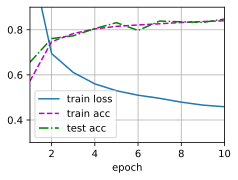

In [14]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(),lr=lr)
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)

- 简洁实现

In [20]:
net = nn.Sequential(nn.Flatten(),
    nn.Linear(784, 256),
    nn.ReLU(),
    # 在第⼀个全连接层之后添加⼀个dropout层
    nn.Dropout(dropout1),
    nn.Linear(256, 128),
    nn.ReLU(),
    # 在第⼆个全连接层之后添加⼀个dropout层
    nn.Dropout(dropout2),
    nn.Linear(128, 10))
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=128, out_features=10, bias=True)
)

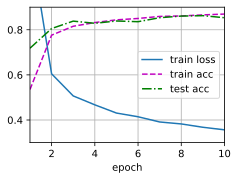

In [21]:
trainer = torch.optim.SGD(net.parameters(),lr=lr)
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)